In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

###Run the stack on two specific images

(1018, 1232)
  (estimateCircleDiameter) nominal dia: 918
  (estimateCircleDiameter) nominal dia: 917
 estimated dia:  917.5
 num circles found:  202


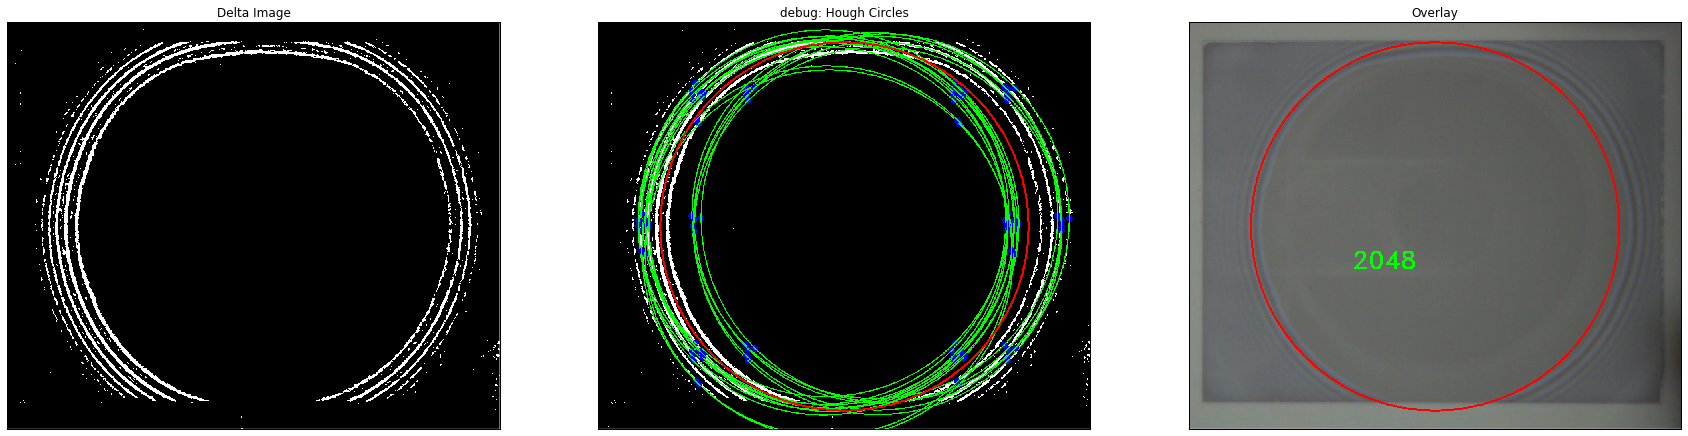

In [4]:
fg_num = 0
# bg_img = eng.images[fg_num-1].copy()
# fg_img = eng.images[fg_num].copy()

bg_img = cv2.imread('../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-1727.png', -1)
bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
fg_img = cv2.imread('../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-1728.png', -1)

thresh_val = 5
img = ip.deltaImage(bg_img, fg_img, thresh_val)

(rows, cols) = img.shape[:2]
print (rows, cols)
centerYX = (513.0, 650.0)
diag_len = int(np.hypot(955, 955))

seed_data = {}
seed_data['img_dims'] = (rows, cols, 3)
seed_data['approx_center_yx'] = ( int(rows/2), int(cols/2) )
seed_data['approx_diameter']  = int(np.hypot(rows, cols))
seed_data['diameter_tolerance']  = 0.20
seed_data['found_first']  = False

ellipse, debug_img = ip.findEllipse(img, seed_data, verbose=True, show_plots=False)

if ellipse[0][0] == -99:
    print "\nUnable to find contact area..."
    overlay = fg_img.copy()
else:
    overlay = fg_img.copy()
    approx_area = (np.pi * np.hypot(ellipse[1][0]/2, ellipse[1][1]/2))
    
    cv2.putText(overlay, ("%d"%(approx_area)), (overlay.shape[0]/2-100, overlay.shape[1]/2), cv2.FONT_HERSHEY_DUPLEX, 2, util.green, 3)
    cv2.ellipse(overlay,ellipse,(255,0,0),4) #cv2.ellipse(img, (centerX,centerY), (width,height), 0, 0, 180, color, lt)
    
util.plot_imgs([(img, 'Delta Image'), (debug_img, 'debug: Hough Circles'),(overlay, 'Overlay')], color=False)    

###Run the stack on folder of images...

In [ ]:
image_folder_lst = ['../projects/contact_front/MR_NewCam']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/transitionSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']

file_spec = '2015-08-04_DFI28-*.png'
glob_spec = "%s/%s" % (image_folder_lst[0], file_spec)

delay_s=0.01
do_plot=False  # must be False for running in notebook
verbose=True

eng = util.Image_Engine(glob_spec, is_glob=True)

ret, stats = ip.processImages_HoughCircles(eng=eng, delay_s=delay_s, do_plot=False, verbose=verbose)
if not ret:
    print "!! Error processing images! ", args.in_file

if len(stats['areas']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot(stats['areas'])
    plt.title('Contact Areas')
    #plt.savefig('../results/%s_ContactAreas.png' % (result_name))

if len(stats['center_pts']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot([x for x,_ in stats['center_pts']])
    plt.plot([y for _,y in stats['center_pts']])
    plt.title('Center XY')
    #plt.savefig('../results/%s_CenterXY.png' % (result_name))

if len(stats['center_pts']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot([x for x,_ in stats['center_pts']], [y for _,y in stats['center_pts']])
    plt.title('Center Locs')
    #plt.savefig('../results/%s_CenterLocs.png' % (result_name))

if len(stats['chan_means']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot([c for c,_,_ in stats['chan_means']], color='b')
    plt.plot([c for _,c,_ in stats['chan_means']], color='g')
    plt.plot([c for _,_,c in stats['chan_means']], color='r')
    plt.title('HSV mean values from center ROI')
    #plt.savefig('../results/%s_HSV-Means.png' % (result_name))
if do_plot: 
    plt.show()

eng.cleanup()

## ----  Sandbox testing:
#### The remaining cells are various tests...

### Create an Image Engine to hold all the images

Read 20 images from ../projects/contact_front/MR_NewCam


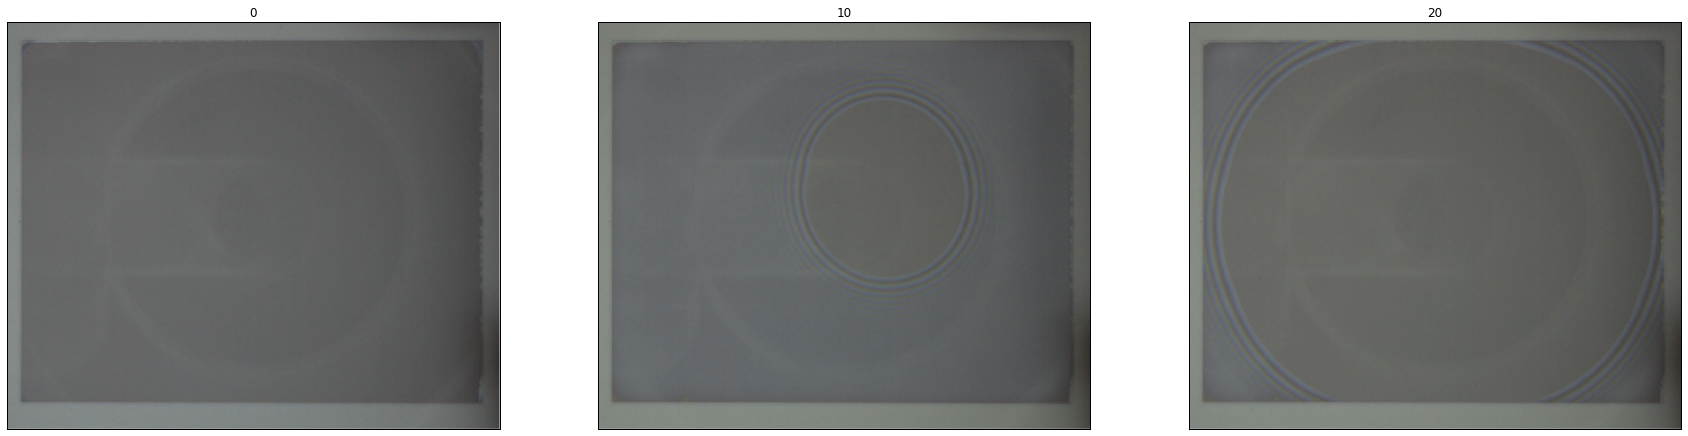

In [3]:
image_folder_lst = ['../projects/contact_front/MR_NewCam']
img_lst = util.Image_List(image_folder_lst, '2015-08-04_DFI28-*.png', doSort=True, color=True)

print "Read %d images from %s" % (img_lst.cnt(), image_folder_lst[0])
util.plot_imgs([(img_lst.images[0], '0'), (img_lst.images[-5], '10'), (img_lst.images[-1], '20')], color=True)

In [ ]:
#  This is the old way to loop through...

plot_lst = []
verbose = True
thresh_val = 7  

image_folder_lst = ['../projects/contact_front/MR_NewCam']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/transitionSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']

file_spec = '2015-08-04_DFI28-*.png'
glob_spec = "%s/%s" % (image_folder_lst[0], file_spec)
image_files = glob.glob(glob_spec)
image_files = sorted(image_files)

start_num = 1
#bg_img = eng.images[start_num-1].copy()
bg_img = cv2.imread(image_files[start_num-1], -1)
bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
(rows, cols) = bg_img.shape[:2]
centerYX = (rows/2, cols/2)
width = cols
height = rows
diag_len = int(np.hypot(rows, cols))

stats = {}
stats['areas'] = []
stats['center_pts']=[]
stats['chan_means'] = []

for img_idx, image_file in enumerate(image_files[start_num:]):
    print "---------------------------------------------------------------------"
    # read next foreground image
    fg_img = cv2.imread(image_file, -1)
    print "FG img rows,cols:", fg_img.shape[:2]

    # let's first analyze a small ROI at the center point
    fg_img_converted = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)
    (rows, cols) = fg_img_converted.shape[:2]
    cp = (int(centerYX[0]), int(centerYX[1]))
    fg_img_converted_roi = fg_img_converted[cp[1]-10:cp[1]+10, cp[0]-10:cp[0]+10]  #np slice: [startY:endY, startX:endX]     
    chan_means = ip.calcChanMeans(fg_img_converted_roi)
    stats['chan_means'].append( (chan_means[0], chan_means[1], chan_means[2]) )
    
    img_full = ip.deltaImage(bg_img, fg_img, thresh_val)

    print("%s[%d]: (%s)%s" % (util.BLUE, img_idx, image_file, util.RESET))
    print("ROI center: (%d, %d), width: %d, height: %d" % (centerYX[0], centerYX[1], width, height))
    #img = extractROI(img_full, (int(centerYX[0]), int(centerYX[1])), int(width), int(height))
    img = img_full
    #print "  >> extracted img size: ", img.shape[:2]
    
    seed_data = {}
    seed_data['img_dims'] = (rows, cols, 3)
    seed_data['approx_center_yx'] = centerYX
    seed_data['approx_diameter']  = diag_len
    seed_data['diameter_tolerance']  = 0.20

    ellipse, output = ip.findEllipse(img, seed_data, verbose, False)
    
    if ellipse[0][0] == -99:
        print("%s Unable to find contact area (%s)%s" % (util.RED, image_file, util.RESET))
        plot_lst.append( (img, 'findEllipse %d' % (img_idx) ))
        stats['areas'].append(np.nan)
        stats['center_pts'].append( (np.nan, np.nan) )
        
        if True:
            bg_img = cv2.imread(image_files[start_num-1], -1)
            bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
            (rows, cols) = bg_img.shape[:2]
            centerYX = (rows/2, cols/2)
            width = cols
            height = rows

    else:        
        overlay = fg_img.copy()
        print ellipse
        pad = 150
        #if ellipse[2] == 0:
        if True:
            centerYX = ((0*centerYX[0] + ellipse[0][1] - 0*height/2), (0*centerYX[1] + ellipse[0][0] - 0*width/2))
        elif ellipse[2] == 90:
            centerYX = ((0*centerYX[0] + ellipse[0][0] - 0*width/2), (0*centerYX[1] + ellipse[0][1] - 0*height/2))
#         width = ellipse[1][0] + pad if (ellipse[1][0] + pad) <= cols else cols
#         height = ellipse[1][1] + pad if (ellipse[1][1] + pad) <= rows else rows
        approx_area = (np.pi * np.hypot(ellipse[1][0]/2, ellipse[1][1]/2))
        diag_len = int(np.max(ellipse[1]) + 150)
        
        stats['areas'].append(approx_area)
        stats['center_pts'].append( (centerYX[1], centerYX[0]) ) # append tuple

        print("%s Success! Contact area: %d %s" % (util.GREEN, approx_area, util.RESET))

        cv2.ellipse(overlay,(centerYX, ellipse[1], ellipse[2]),(255,0,0),4) #cv2.ellipse(img, (centerX,centerY), (width,height), 0, 0, 180, color, lt)
        cv2.putText(overlay, ("%d"%(approx_area)), (int(centerYX[0])-100, int(centerYX[1])), cv2.FONT_HERSHEY_DUPLEX, 2, util.green, 3)
        plot_lst.append( (overlay, 'findEllipse %d' % (img_idx) ))
        bg_img = cv2.GaussianBlur(fg_img, (5, 5), 0)
        

plt.figure(figsize=(10*2,5))
plt.plot(stats['areas'])
plt.title('Contact Areas')

plt.figure(figsize=(10*2,5))
plt.plot([x for x,_ in stats['center_pts']])
plt.plot([y for _,y in stats['center_pts']])
plt.title('Center points')

plt.figure(figsize=(10*2,5))
plt.plot([x for x,_ in stats['center_pts']], [y for _,y in stats['center_pts']])
plt.title('Center locs')

plt.figure(figsize=(10*2,5))
plt.plot([c for c,_,_ in stats['chan_means']], color='b')
plt.plot([c for _,c,_ in stats['chan_means']], color='g')
plt.plot([c for _,_,c in stats['chan_means']], color='r')
plt.title('HSV mean values from center ROI')

if False:
    plt.figure.max_num_figures=len(image_files) + 10
    plt.rcParams['figure.max_open_warning'] = 0
    util.plot_imgs(plot_lst)

###Separate into HSV color channels

In [ ]:
plot_lst = []
img_hsv = cv2.cvtColor(eng.images[9], cv2.COLOR_BGR2HSV)
plot_lst.append( (img_hsv, 'img_hsv') )

chan = ('0','1','2')
for chan_idx, chan in enumerate(chan):
    chan_img = cv2.split(img_hsv)[chan_idx]
    plot_lst.append( (chan_img, 'img_hsv - chan %d' % (chan_idx)) )
    
util.plot_imgs(plot_lst, max_cols=4)

###Experiment with diffing some of the channels

In [ ]:
plot_lst = []
img_split = cv2.split(img_hsv)

frameDelta1 = cv2.absdiff(img_split[1], img_split[0])
plot_lst.append( (frameDelta1, 'frameDelta 0 - 1') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[0])
plot_lst.append( (frameDelta2, 'frameDelta 0 - 2') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[1])
plot_lst.append( (frameDelta2, 'frameDelta 2 - 1') )

util.plot_imgs(plot_lst, max_cols=4)

###Do some thresholding to try and isolate contact area and fringes

In [ ]:
plot_lst = []

fg_num = 15

# first, get the background image ROI
bg_img = eng.images[fg_num-1]
bg_img_gray = cv2.cvtColor(bg_img, cv2.COLOR_BGR2GRAY)
bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)

fg_img = eng.images[fg_num]

#avg = bg_img.copy().astype("float")
# plot_lst.append((bg_img, 'background'))
# plot_lst.append( (fg_img, 'img %d' % fg_num) )

img = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)
chan = cv2.split(img)[2]
chan_blurred = cv2.medianBlur(chan, 5)

fg_img_gray = cv2.cvtColor(fg_img, cv2.COLOR_BGR2GRAY)
#chan_blurred2 = cv2.medianBlur(fg_img_gray, 5)
chan_blurred2 = cv2.GaussianBlur(fg_img_gray, (5, 5), 0)

plot_lst.append( (chan_blurred, 'chan_blurred') )
plot_lst.append( (chan_blurred2, 'chan_blurred2') )

frameDelta1 = cv2.absdiff(bg_img_gray, chan_blurred)
plot_lst.append( (frameDelta1, 'frameDelta1') )

# frameDelta1_roi = frameDelta1[238:386, 222:366]  #np slice: [startY:endY, startX:endX]
frameDelta1_roi = ip.extractROI(frameDelta1, (700, 454), 766, 760)
plot_lst.append( (frameDelta1_roi, 'frameDelta1_roi') )

L = frameDelta1_roi.max() - frameDelta1_roi.min()
print L

hist = np.bincount(frameDelta1_roi.ravel(), minlength=3)
hist_diff = np.abs(np.diff(hist))
plt.plot(hist)
plt.title("Histogram")
plt.show()
plt.plot(hist_diff)
plt.title("Histogram Diff")
plt.show()

hist = cv2.calcHist([frameDelta1_roi],[0],None,[256],[0,256])
plt.plot(hist[0:L])
plt.title("Histogram - Bins: max - min")
plt.show()

print hist_diff[0:20]

(rows, cols) = frameDelta1_roi.shape[:2]
frameDelta1_patch = ip.extractROI(frameDelta1_roi, (rows/2, cols/2), cols, 10)
plot_lst.append( (frameDelta1_patch, 'frameDelta1_patch') )

frameDelta1_patch_mean = np.abs(np.mean(frameDelta1_patch, axis=0))
frameDelta1_patch_diff = np.abs(np.diff(frameDelta1_patch_mean))
plt.plot(frameDelta1_patch_mean)
plt.title("Cross section of frameDelta1_patch")
plt.show()

util.plot_imgs(plot_lst)

In [ ]:
plot_lst = []
thresh_val = 6
val = 255

#thresh1 = cv2.adaptiveThreshold(frameDelta1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 5)
ret,thresh1 = cv2.threshold(frameDelta1,thresh_val,val,cv2.THRESH_BINARY)
plot_lst.append( (thresh1, 'thresh1') )

thresh1_smooth = cv2.GaussianBlur(thresh1, (15, 15), 2)
plot_lst.append( (thresh1_smooth, 'thresh1_smooth') )

util.plot_imgs(plot_lst)

In [ ]:
#bg_img = eng.images[0]
fg_num = 3
bg_img = eng.images[fg_num-1].copy()
fg_img = eng.images[fg_num].copy()

img_full = ip.deltaImage(bg_img, fg_img, thresh_val)

if fg_num > 8:
    img = ip.extractROI(img_full, (700, 454), 766, 760)
    fg_img = ip.extractROI(fg_img, (700, 454), 766, 760)
else:
    img = img_full

(rows, cols) = img.shape[:2]
if verbose: print "cols, rows: ", cols, rows
center_pt = (cols/2, rows/2)
# pt = (center[1]+(376/2), center[0]-(488/2))
end_pt=(cols-1, 1)
offset=(0, -976)
if verbose: print "center pt: ", center_pt, "end pt: ", end_pt
util.plot_imgs([(bg_img, 'Background Image'), (fg_img, 'Raw Image'), (img, 'Delta Image')], color=False)

###Quick cell to find delta between two images

In [ ]:
bg_img = cv2.imread('../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-1849.png', -1)
#bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
fg_img = cv2.imread('../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-1850.png', -1)

thresh_val = 5
img_delta = ip.deltaImage(bg_img, fg_img, thresh_val)

img_delta2 = cv2.absdiff(bg_img, fg_img)

util.plot_imgs([(fg_img, 'fg_img'), (img_delta, 'img_delta'),(img_delta2, 'img_delta2')], color=False)    

In [ ]:
###
###  This version uses the image engine...it gets bogged down with so many images...
###
plot_lst = []
verbose = True

image_folder_lst = ['../projects/contact_front/MR_NewCam']
file_spec = '2015-08-04_DFI28-*.png'
print "Read %d images from %s" % (eng.cnt(), image_folder_lst[0])
eng = util.Image_Engine(image_folder_lst, file_spec, doSort=True, color=True)

thresh_val = 10

start_num = 4
bg_img = eng.images[start_num-1].copy()
bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
(rows, cols) = bg_img.shape[:2]
center = (cols/2, rows/2)
width = cols
height = rows

areas = []
for img_idx, fg_img in enumerate(eng.images[start_num:]):
    print "---------------------------------------------------------------------"
    img_full = deltaImage(bg_img, fg_img, thresh_val)

    print("Starting img[%d]: ROI center: (%d, %d), width: %d, height: %d" % (img_idx, center[0], center[1], width, height))
    img = extractROI(img_full, (int(center[0]), int(center[1])), int(width), int(height))
    #print "  >> extracted img size: ", img.shape[:2]
    
    ellipse, output = findEllipse(img, verbose)
    if ellipse[0][0] == -99:
        print "Unable to find contact area on img: ", (img_idx)
        plot_lst.append( (img, 'findEllipse %d' % (img_idx) ))
        areas.append(0)
    else:
        print "Found contact area on img: ", (img_idx)
        overlay = fg_img.copy()
        
        center = ((center[0] + ellipse[0][0] - width/2), (center[1] + ellipse[0][1] - height/2))
        width = ellipse[1][0] + 175
        height = ellipse[1][1] + 175
        approx_area = np.pi * (width/2) * (height/2)
        areas.append(approx_area)
        
        cv2.ellipse(overlay,(center, ellipse[1], ellipse[2]),(255,0,0),4) #cv2.ellipse(img, (centerX,centerY), (width,height), 0, 0, 180, color, lt)
        cv2.putText(overlay, ("%d"%(approx_area)), (int(center[0])-100, int(center[1])), cv2.FONT_HERSHEY_DUPLEX, 2, util.green, 3)
        plot_lst.append( (overlay, 'findEllipse %d' % (img_idx) ))
        bg_img = cv2.GaussianBlur(fg_img, (5, 5), 0)

plt.plot(areas)
        
if False:
    util.plot_imgs(plot_lst)

n=  1230
threshold:  46.21875
  peakIdx, delta: 436 86.0625
threshold:  43.03125
  peakIdx, delta: 490 92.4375
  peaks: [(436, 86.0625), (490, 92.4375)]
>>> lt_peakIdx: 179, rt_peakIdx: 1105
>>> nominal width: 926


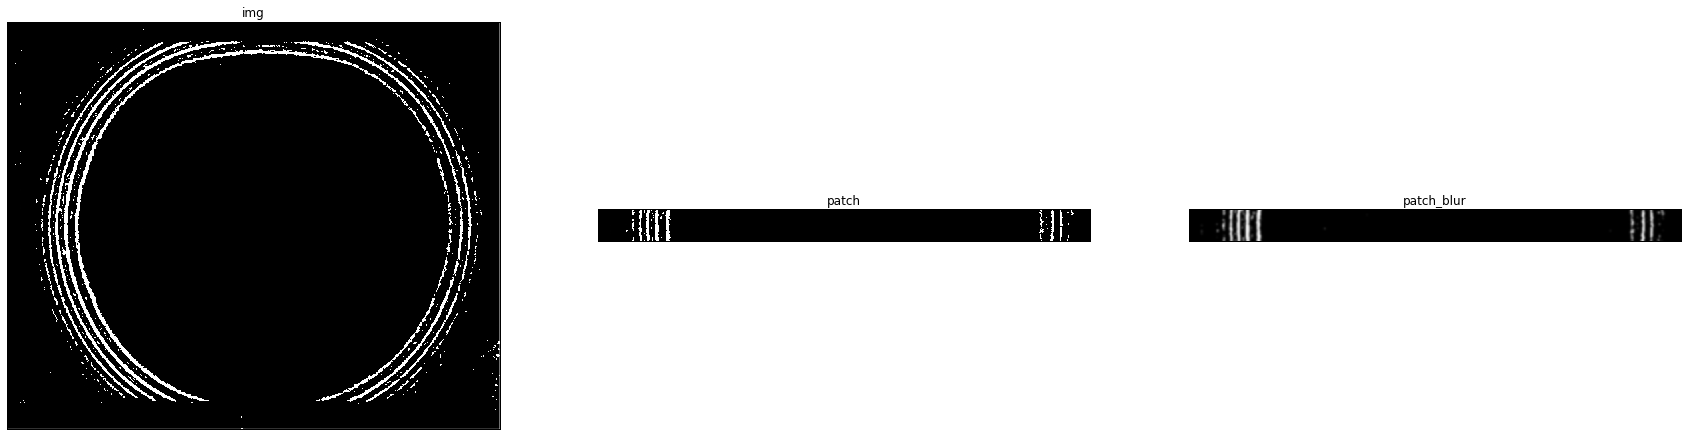

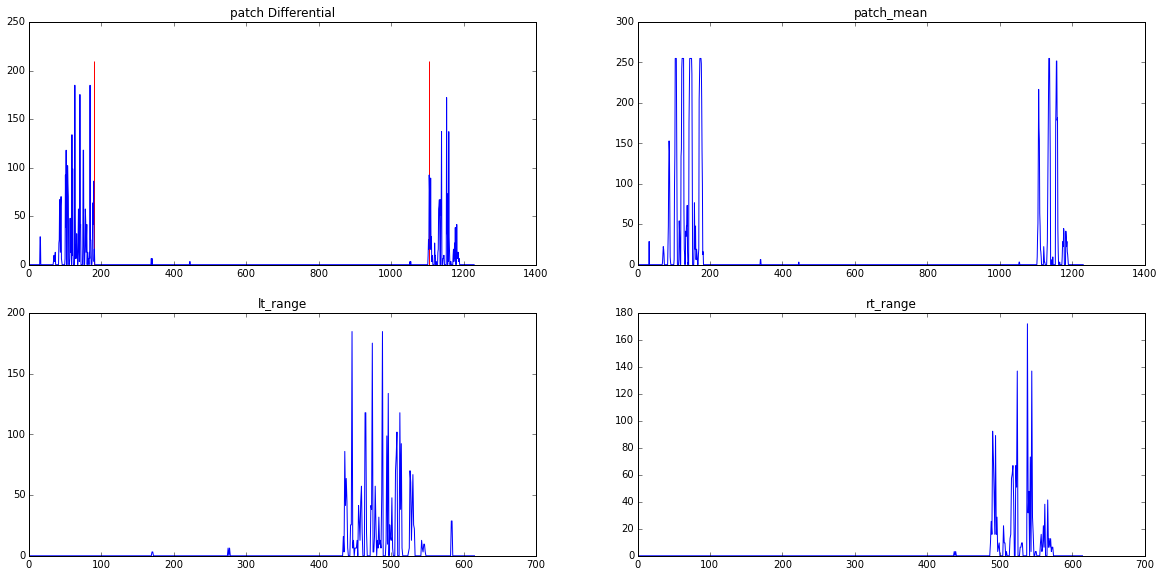

In [44]:
# find width of circle
(rows, cols) = img.shape[:2]

start_pt = (0, rows/2)
end_pt   = (cols-1, rows/2)

patch = img[rows/2-40:rows/2+40, 0:cols-1 ]  #np slice: [startY:endY, startX:endX]
#patch = rotateImage(img, np.rad2deg(theta_rad))
patch_blur = cv2.GaussianBlur(patch, (15, 15), 0)

#cv2.line(img, start_pt, end_pt, (255, 255, 255), 3)
util.plot_imgs([(img, 'img'), (patch, 'patch'), (patch_blur, 'patch_blur')], color=False)

patch_mean = np.abs(np.mean(patch, axis=0))
patch_diff = np.abs(np.diff(patch_mean))

n = patch_diff.size
print "n= ", n
ranges = []
lt_range = patch_diff[n/2::-1]
rt_range = patch_diff[n/2:]
ranges.append(lt_range)
ranges.append(rt_range)

peak_sets = []
for r in ranges:
    delta_threshold = np.max(r) * 0.25
    print "threshold: ", delta_threshold
    idx_jumps = []
    for idx, delta in enumerate(r):
        if delta > delta_threshold:
            idx_jumps.append( (idx, delta) )
            #print("  idx_jump found: idx=%d, delta=%d" % (idx, delta))
    if len(idx_jumps) > 0:
        peak_set = idx_jumps[0]
        print "  peakIdx, delta:", peak_set[0], peak_set[1]
    else:
        peak_set = (-99, 0)
    peak_sets.append(peak_set)
print "  peaks:", peak_sets

lt_peakIdx = n/2 - peak_sets[0][0]
rt_peakIdx = n/2 + peak_sets[1][0]
print(">>> lt_peakIdx: %d, rt_peakIdx: %d" % (lt_peakIdx,rt_peakIdx))
print(">>> nominal width: %d" % (rt_peakIdx-lt_peakIdx))

plt.figure(figsize=(10*2,10*2))
plt.subplot(421)
plt.plot(patch_diff)
plt.vlines(lt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
plt.vlines(rt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
plt.title('patch Differential')
plt.subplot(422)
plt.plot(patch_mean)
plt.title('patch_mean')
plt.subplot(423)
plt.plot(lt_range)
plt.title('lt_range')
plt.subplot(424)
plt.plot(rt_range)
plt.title('rt_range')

In [ ]:
## Aug 14, AM: this works!

sample_halfWidth = 80
# extract patch along center-width
(rows, cols) = img.shape[:2]
patch_w = img[rows/2-sample_halfWidth:rows/2+sample_halfWidth, 0:cols-1 ]  #np slice: [startY:endY, startX:endX]
patch_w = cv2.GaussianBlur(patch_w, (15, 15), 0)

patch_h = img[0:rows-1, cols/2-sample_halfWidth:cols/2+sample_halfWidth ]  #np slice: [startY:endY, startX:endX]
patch_h = cv2.GaussianBlur(patch_h, (15, 15), 0)
patch_h = np.rot90(patch_h)

util.plot_imgs([(img, 'img'), (patch_w, 'patch_w'), (patch_h, 'patch_h')], color=False)

# find mean, diff
patch_w_mean = np.abs(np.mean(patch_w, axis=0))
patch_w_diff = np.abs(np.diff(patch_w_mean))
patch_h_mean = np.abs(np.mean(patch_h, axis=0))
patch_h_diff = np.abs(np.diff(patch_h_mean))

patches = []
patches.append(patch_w_diff)
patches.append(patch_h_diff)

dia=[]
for patch_diff in patches:
    # split into two ranges: middle->left, middle->right
    n = patch_diff.size
    ranges = []
    lt_range = patch_diff[n/2::-1]
    rt_range = patch_diff[n/2:]
    ranges.append(lt_range)
    ranges.append(rt_range)

    # iter through each range, find the first peak past threshold
    peak_sets = []
    for r in ranges:
        delta_threshold = np.max(r) * 0.25
        #print "threshold: ", delta_threshold
        idx_jumps = []
        for idx, delta in enumerate(r):
            if delta > delta_threshold:
                idx_jumps.append( (idx, delta) )
                #print("  idx_jump found: idx=%d, delta=%d" % (idx, delta))
        if len(idx_jumps) > 0:
            peak_set = idx_jumps[0]
            print "  peakIdx, delta:", peak_set[0], peak_set[1]
        else:
            peak_set = (-99, 0)
        peak_sets.append(peak_set)
    print "  peaks:", peak_sets

    lt_peakIdx = n/2 - peak_sets[0][0]
    rt_peakIdx = n/2 + peak_sets[1][0]
    print(">>> lt_peakIdx: %d, rt_peakIdx: %d" % (lt_peakIdx,rt_peakIdx))
    print(">>> nominal dia: %d" % (rt_peakIdx-lt_peakIdx))
    dia.append(rt_peakIdx-lt_peakIdx)

    plt.figure(figsize=(10*2,5))
    plt.subplot(131)
    plt.plot(patch_diff)
    plt.vlines(lt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
    plt.vlines(rt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
    plt.title('patch Differential')
    plt.subplot(132)
    plt.plot(lt_range)
    plt.title('lt_range')
    plt.subplot(133)
    plt.plot(rt_range)
    plt.title('rt_range')

dia_np=np.array(dia)
print "dia_mean: ", dia_np.mean()

### 